In [2]:
import vector
import jax
import madjax as mj
import numpy as np
import matplotlib.pyplot as plt

/Users/lukasheinrich/Code/iml_tutorial/_venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# MadJax Intro

`madjax` is a package that gives you access to Matrix Element calculations from `MadGraph` but in a fully differentiable way.

Traditionally `MadGraph` provides the user with two things:

1. Matrix Element Calculations to compute the relative prob of an event scattering into a given phase space point $x$

$$\frac{d\sigma(x)}{d\Omega} \sim |\mathcal{M}|^2(x)$$


This involves e.g. parsing a user-defined process string like 

```
generate e+ e- > mu+ mu-
```

and listing all possible Feynman Diagrams for the desired process. Once `MadGraph` has all the desired diagrams it *generates code* for each of these sub-processes in order to compute $|\mathcal{M}|^2$

The computed Matrix Element of course depends on various constants of nature such as couplings, particle masses and so on: $\alpha_s$, $M_Z$

So the total Matrix Element depends on not only the phase-space point $x$ but also on the parameters $\theta$

$$\frac{d\sigma(x)}{d\Omega} \sim |\mathcal{M}|^2(x,\theta)$$




2. Another feature that `MadGraph` provides is event generation.

That is `MadGraph` can sample events *according to their relative probabilities* as computed by 1). This results e.g. in events in LHE files that you can then use to produce further simulated Monte-Carlo samples for HEP analysis


## `madjax`

The main feature of `madjax` is to expand the code generation capabilities of `MadGraph` in order to provide a **differentiable** version of  $|\mathcal{M}|^2(x,\theta)$ such that you can compute derivatives with respect to the phase-space

$$\nabla_x |\mathcal{M}|^2(x,\theta)$$

... but also with respect to the theory parameters:

$$\nabla_\theta |\mathcal{M}|^2(x,\theta)$$ 


### Generating `madjax`-enabled Matrix Element Code

In this tutorial you already have a ready-generated code in the `iml_example` directory but it's useful to know how to generate it yourself

1. Installing `madjax`


If you want to install `madjax` locally (outside of this binder) you can simply run

`pip install madjax`

or if you want to have the bleeding edge (use for this tutorial)

`pip install git+https://github.com/madjax-hep/madjax@master#egg=madjax`


The `madjax` package comes with a commadn `madjax-config` that give you the path to the `madjax` plugin code. In order to make this visible to `MadGraph` this code must be put into the `PLUGINS` directory of `MadGraph`

2. Generating `madjax` code


In order to generate `madjax` code it's enough to change your usual madgraph. The code generation is triggered by the `output madjax <directory name>` line

```
$> cat madjax.mg5
generate e+ e- > mu+ mu- 
output madjax iml_example
```

You can then run 

```
mg5_aMC --mode=madjax_me_gen madjax.mg5
```

in order to genrate the code. This will produce output like 


```
...
INFO: Trying process: e+ e- > mu+ mu- WEIGHTED<=4 @1  
INFO: Process has 2 diagrams 
1 processes with 2 diagrams generated in 0.034 s
Total: 1 processes with 2 diagrams
output madjax iml_example
Output will be done with PLUGIN: madjax_me_gen
INFO: Organizing processes into subprocess groups 
INFO: Generating Helas calls for process: e+ e- > mu+ mu- WEIGHTED<=4 @1 
INFO: Processing color information for process: e+ e- > mu+ mu- @1 
MG5aMC_PythonMEs.MEExporter: Now generating Python output for process: e+ e- > mu+ mu- WEIGHTED<=4 @1
Generated helas calls for 1 subprocesses (2 diagrams) in 0.023 s
MG5aMC_PythonMEs.MEExporter: Now outputting the model...
ALOHA: aloha starts to compute helicity amplitudes
ALOHA: aloha creates 3 routines in  1.481 s
MG5aMC_PythonMEs.MEExporter: Created parameters python file /Users/lukasheinrich/Code/madjaxdev/examples/iml_example/model/parameters.py.
MG5aMC_PythonMEs.MEExporter: Finalizing...
```

## Generating `madjax` code with `docker`

Once the code generated `madjax` is totally independent from `MadGraph` and works in environments (such as this one), where no `MadGraph` is installed. Given this, it's useful to know how to generate `madjax` code in a self-contained why without a local install of `MadGraph`. 

We can do this with the software virtualization tool `docker` and use Matthew Feickers famous `MadGraph` images

Let's pull the image

```
docker pull scailfin/madgraph5-amc-nlo:mg5_amc3.3.2
```

Now to generate madgraph code we only need to make the `madjax` plugin available inside of the `docker` image and run `MadGraph`

```
docker run \
-v $PWD:$PWD -w $PWD \
-v `madjax-config`:/usr/local/venv/MG5_aMC/PLUGIN/madjax_me_gen \
scailfin/madgraph5-amc-nlo:mg5_amc3.3.2 \
"mg5_aMC --mode=madjax_me_gen madjax.mg5"
```

This command should produce the `iml_example` directory that you see in this tutorial


From here on out, we will work only with this example process 

$$e^+ e^- > \mu^+ \mu^-$$


## Loading MadJax code

`madjax` provides a nice API in order to access the Matrix Element code that `MadGraph` generated in `jax` format

In [6]:
me_codes = mj.MadJax('iml_example')

We can look at the available combinations of initial and final states for which code has been generated (in case you e.g. have processes with all flavors, etc)

In this case it's easy, just a single initial and final state


In [8]:
me_codes.processes

{'Matrix_1_epem_mupmum': iml_example.processes.all_processes.Matrix_1_epem_mupmum}

We can now get the function of purely the computed Matrix Element by passing in the process name and a center of mass energy (in GeV)

In [11]:
E_cm = 90 # GeV
madjax_func = me_codes.matrix_element(E_cm,'Matrix_1_epem_mupmum', return_grad=False)

As discussed the matrix element is function of the phase space point as well as the theory parameters. Even in the Standard Model there are typically many theory parameters we would want to not touch and specify each time we want to evaluate a matrix element.

That's why the signature of `madjax_func` is 

```
madjax_func(<dict of theory parameters to override>, <phase space point> )
```

The first argument is a dictionary of which subset of $\theta$ you want to set and/or override.

The second argument is the phase space point parametrized by 3*n-4 numbers in the interval [0,1] (we will get to this later)


We can evaluate the Matrix Element at the default value of the parameters like so:


In [15]:
madjax_func({}, [0.2,0.3])

DeviceArray(1.22579846, dtype=float64)

## Phasespace

Great! But what does this [0.2,0.2] mean? If you have $n$ external particles in a diagram (for us $n$=2) you have $4n$ components of 4-vectors. But for each particle you have the constraint that the 4-vector must be "on-shell" $E^2-p^2 = m^2$. This brings the number of free parameters down to $3n$.

Furthermore, you have the constraint that the overall 4-vector that goes into the diagram must also come out, which gives you another 4 constraints for each of ($E$,$p_x$,$p_y$,$p_z$). This leads you to the overall number of free parameters:

$$N_\mathrm{pars} = 3n - 4$$

For our diagram with 2 outgoing particles we thus have

$$3n-4 = 2$$ free parameters

That is the `2x4=8` components of the outgoing particle configuration is actually only parametrized by 2 parameters. We can see how this works using `madjax` 


In [40]:
ps_maker = me.phasespace_vectors(E_cm,'Matrix_1_epem_mupmum')

vectors = ps_maker({},[0.2,0.3])
print(vectors)

[[ 45.           0.           0.          45.        ]
 [ 45.           0.           0.         -45.        ]
 [ 45.         -11.1246118   34.23803459 -27.        ]
 [ 45.          11.1246118  -34.23803459  27.        ]]


This gives both input and output 4-vectors but let's focus on the outgoing particles

In [41]:
outgoing = vectors[2:]
outgoing.shape

(2, 4)

We could even pass this into our favorite 4-vector package `vector` from `scikit-hep` like so

In [42]:
outgoing = vector.array(dict(zip(['E','x','y','z'],outgoing.T)))
outgoing

MomentumNumpy4D([(-11.1246118,  34.23803459, -27., 45.),
                 ( 11.1246118, -34.23803459,  27., 45.)],
                dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

... and evaluate the more convenient attributes like pseudorapidity $\eta$ and $\phi$

In [43]:
outgoing.eta, outgoing.phi

(array([-0.69314718,  0.69314718]), array([ 1.88495559, -1.25663706]))

In [44]:
print(outgoing[0].phi-outgoing[1].phi == np.pi) #pi
print(outgoing[0].eta == -outgoing[1].eta)

True
True


We can see clearly that the two particles are back to back!

Based on this we can see what the two numbers [0,1]^2 (which we will call hypercube parameters) actually mean here

In [47]:
ps_maker = me.phasespace_vectors(E_cm,'Matrix_1_epem_mupmum')
hyper2vec =  lambda ps: ps_maker({},ps)[2:] #pick up final state

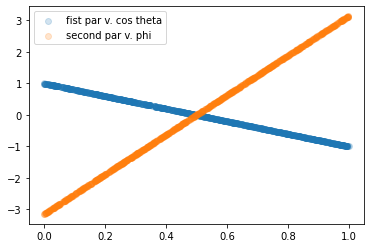

In [51]:
ps_points = np.random.uniform([0.0,0.0],[1,1], size = (1000,2))
vectors = jax.vmap(hyper2vec)(ps_points)

vectors = vector.array(dict(zip(['E','x','y','z'],vectors.T)))
plt.scatter(ps_points[:,0],np.cos(vectors.theta[1]),alpha = 0.2, label = 'fist par v. cos theta')
plt.scatter(ps_points[:,1],vectors.phi[1],alpha = 0.2, label = 'second par v. phi')
plt.legend()

We can see that the first parameter corresponds to the polar angle $cos\theta$.

The second parameter to the azimuthal angle $\phi$

## Mapping the Matrix Element

We can now try to get a feel for the matrix element we generated by using `jax`'s nice `vmap` capabilities to evaluate the matrix element on a grid of $\cos\theta$ and $\phi$

In [56]:
p1_range = np.linspace(0,1,101)
p2_range = np.linspace(0,1,101)

grid = np.meshgrid(p1_range, p2_range, indexing='ij')
X = np.swapaxes(grid,0,-1).reshape(-1,2)

print(X)

[[0.   0.  ]
 [0.01 0.  ]
 [0.02 0.  ]
 ...
 [0.98 1.  ]
 [0.99 1.  ]
 [1.   1.  ]]


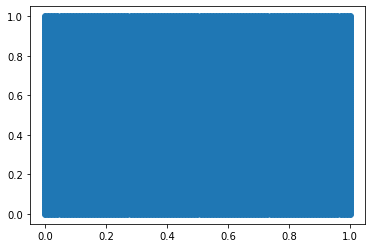

In [57]:
plt.scatter(X[:,0],X[:,1])

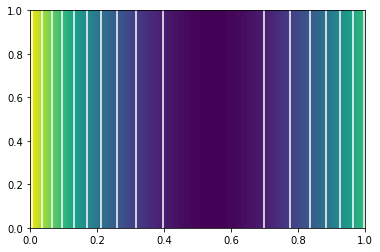

In [64]:
results = jax.vmap(madjax_func, in_axes = (None,0))({}, X)
results = results.reshape(len(p1_range),len(p2_range)).T
plt.contourf(grid[0],grid[1],results, levels = 101)
plt.contour(grid[0],grid[1],results, levels = 10, colors = 'w')

The matrix element only depends on $\cos \theta$ as we would expect if we remember our introduction to QFT class
where $$\frac{d\sigma}{d\Omega} \sim (1+\cos^2\theta)$$

As $\phi$ does not matter, let's look at a single slice in $\phi$ as a function purely of $\cos\theta$

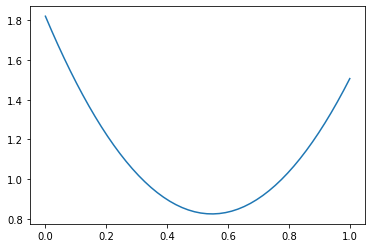

In [76]:
xi = np.array(list(np.broadcast(np.linspace(0,1),0.5)))
yi = jax.vmap(madjax_func, in_axes = (None,0))({}, xi)
plt.plot(xi[:,0],yi, label = 'M^2')

## Overriding Parameters

The process $e^+ e^- > \mu^+ \mu^-$ strongly depends on the value of the Z-boson mass
We can now look at the same function at various values of $M_Z$

The PDG Code of the Z-boson is 23, and we can override the matrix element calculation with this mass like so:

In [82]:
print(madjax_func({}, [0.2,0.3]), 'E_cm at 90 GeV, Z mass at default')
print(madjax_func({("mass", 23): 85}, [0.2,0.3]), 'E_cm at 90 GeV, Z mass at 85 GeV')

1.225798457760036 E_cm at 90 GeV, Z mass at default
0.049994072666759 E_cm at 90 GeV, Z mass at 85 GeV


[]

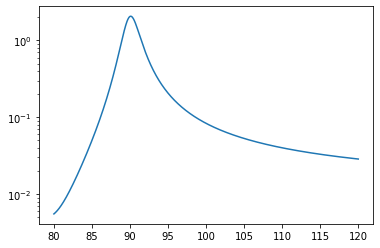

In [90]:
masses = np.linspace(80,120,1001)
func = lambda mass: madjax_func({("mass", 23): mass}, [0.2,0.3])
me_value = jax.vmap(func)(masses)
plt.plot(masses,me_value)
plt.semilogy()

The main point of `madjax` is that it's differentiable, so let's try to get the derivatives of $|\mathcal{M}|^2(x,m_Z)$ from `madjax`

It's as simple as calling `jax.value_and_grad` on the code above

(85.0, 95.0)

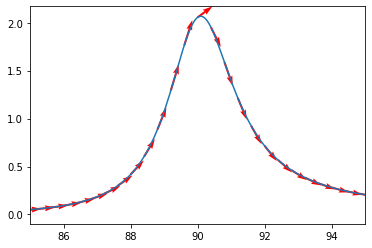

In [101]:
me_value,me_grads = jax.vmap(jax.value_and_grad(func))(masses)
plt.plot(masses,me_value)
n_every = 10
plt.quiver(masses[::n_every],me_value[::n_every],jax.numpy.ones_like(me_grads[::n_every]),me_grads[::n_every],units='xy',angles='xy', color = 'r')
plt.xlim(85,95)

<h2> Voilà! - Differentiable Matrix Elements!</h2>

For more information please check out this paper on the arxiv

https://arxiv.org/abs/2203.00057

L. Heinrich, M. Kagan - Differentiable Matrix Elements with MadJax
    